In [56]:
using Revise
using Turing, MCMCChains
using XLSX
using DataFrames, TimeSeries
using StatsPlots
using Plots
using LinearAlgebra
using CSV
using StatsBase
include("../utils.jl")
include("../financial_bvar_temp.jl")
using .FinancialBVAR

In [20]:
df = DataFrame(XLSX.readtable("../data/usa_var_data.xlsx", "Data", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :Date), Dates.quarter, last)

292×11 TimeArray{Float64, 2, Date, Matrix{Float64}} 1951-12-01 to 2024-07-01
┌────────────┬──────────┬───────────┬─────────────┬──────────┬────────┬─────────
│            │ Yeld_10Y │ Price_10Y │ Stock_Price │ Dividend │ E      │ CAPE   ⋯
├────────────┼──────────┼───────────┼─────────────┼──────────┼────────┼─────────
│ 1951-12-01 │  0.02513 │   104.098 │       24.19 │  1.41333 │   2.44 │ 12.527 ⋯
│ 1952-03-01 │  0.02505 │   104.824 │       23.74 │     1.43 │    2.4 │ 12.242 ⋯
│ 1952-06-01 │  0.02415 │   106.295 │       25.08 │     1.45 │   2.34 │ 12.669 ⋯
│ 1952-09-01 │  0.02685 │   104.468 │       24.26 │  1.43667 │   2.36 │ 12.131 ⋯
│ 1952-12-01 │  0.02547 │   106.402 │       26.18 │     1.41 │    2.4 │ 13.010 ⋯
│ 1953-03-01 │  0.02735 │   105.373 │       24.71 │  1.41333 │   2.43 │ 12.163 ⋯
│ 1953-06-01 │  0.02987 │    103.86 │       24.29 │     1.42 │   2.51 │ 11.750 ⋯
│ 1953-09-01 │  0.02636 │    107.81 │       23.97 │     1.43 │   2.55 │ 11.391 ⋯
│     ⋮      │    ⋮     │     ⋮ 

In [3]:
returns = percentchange(data_source[:Total_Stock, :Price_10Y], :log)
returns = merge(returns, log1p.(data_source[:T_Bill])./4)
cpi = percentchange(data_source[:CPI], :log)
real_returns = returns .- cpi
term = data_source[:Yeld_10Y] ./4 .- data_source[:T_Bill] ./4
dy = data_source[:Dividend_Yeld] #log.(data_source[:Dividend_Yeld])
data = merge(real_returns, dy, term, cpi)

291×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1952-03-01 to 2024-07-01
┌────────────┬─────────────────┬───────────────┬─────────────┬───────────────┬──
│            │ Total_Stock_CPI │ Price_10Y_CPI │ T_Bill_CPI  │ Dividend_Yeld │ ⋯
├────────────┼─────────────────┼───────────────┼─────────────┼───────────────┼──
│ 1952-03-01 │      1.98335e-5 │     0.0107337 │  0.00772445 │     0.0602359 │ ⋯
│ 1952-06-01 │       0.0581411 │    0.00263202 │ -0.00708528 │      0.057815 │ ⋯
│ 1952-09-01 │      -0.0185027 │    -0.0173351 │  0.00423886 │     0.0592197 │ ⋯
│ 1952-12-01 │       0.0932838 │     0.0220972 │   0.0089235 │     0.0538579 │ ⋯
│ 1953-03-01 │      -0.0437093 │   -0.00972202 │  0.00497517 │     0.0571967 │ ⋯
│ 1953-06-01 │      -0.0100139 │    -0.0219485 │ -0.00227055 │     0.0584603 │ ⋯
│ 1953-09-01 │     -0.00574595 │     0.0298874 │ -0.00299956 │     0.0596579 │ ⋯
│ 1953-12-01 │        0.078226 │     0.0248173 │  0.00767892 │     0.0572141 │ ⋯
│     ⋮      │        ⋮        │ 

In [4]:
CSV.write("../data/usa_data_transformed.csv", data)

"../data/usa_data_transformed.csv"

In [5]:
start = Date(1983,03,01)
end_d = Date(2019, 12, 31)
s_data = to(from(data, start),end_d)

148×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1983-03-01 to 2019-12-01
┌────────────┬─────────────────┬───────────────┬─────────────┬───────────────┬──
│            │ Total_Stock_CPI │ Price_10Y_CPI │ T_Bill_CPI  │ Dividend_Yeld │ ⋯
├────────────┼─────────────────┼───────────────┼─────────────┼───────────────┼──
│ 1983-03-01 │       0.0916672 │    0.00192869 │   0.0119025 │     0.0438808 │ ⋯
│ 1983-06-01 │       0.0544534 │    -0.0072674 │  0.00796388 │     0.0416766 │ ⋯
│ 1983-09-01 │      0.00376823 │    -0.0107314 │   0.0105936 │     0.0419201 │ ⋯
│ 1983-12-01 │     -0.00592333 │   -0.00188541 │    0.012673 │     0.0427885 │ ⋯
│ 1984-03-01 │      -0.0544437 │    -0.0222866 │   0.0110268 │     0.0458333 │ ⋯
│ 1984-06-01 │      -0.0397357 │    -0.0482265 │   0.0138793 │      0.048533 │ ⋯
│ 1984-09-01 │       0.0861884 │     0.0948199 │   0.0132056 │      0.045085 │ ⋯
│ 1984-12-01 │       0.0496119 │     0.0795741 │   0.0174816 │     0.0441336 │ ⋯
│     ⋮      │        ⋮        │ 

In [6]:
returns_summarystats(to(from(returns, start),end_d), 4)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.1371,0.7827,0.1081,0.2693,-1.0147,-0.8517,-0.0057,0.137,2.0354,0.7885,0.1463
Price_10Y,0.0833,0.5691,0.0704,0.1747,-0.2868,0.4522,-0.0411,0.0503,0.0835,0.8451,0.0465
T_Bill,0.0135,0.0987,0.0349,0.0543,0.0001,0.2748,0.0094,0.9738,-0.9875,2.5867,0.0352


In [7]:
returns_summarystats(s_data, 1)
display("Annulaised data")
returns_summarystats(s_data, 4)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_CPI,0.0686,0.1938,0.0205,0.0609,-0.2381,-0.7125,-0.01,0.1159,1.6044,0.2982,0.0281
Price_10Y_CPI,0.0439,0.1677,0.011,0.0381,-0.0763,0.5516,-0.0198,0.0387,0.5188,0.2517,0.0057
T_Bill_CPI,0.008,0.0255,0.0022,0.0076,-0.0208,-0.1359,-0.0028,0.2722,0.479,0.2718,0.0033
Dividend_Yeld,0.0087,0.0485,0.0238,0.0298,0.0113,0.8748,0.0178,0.9596,-0.0527,2.7444,0.0205
Yeld_10Y_T_Bill,0.0028,0.0099,0.0046,0.0068,-0.0016,-0.1846,0.0024,0.8688,-0.9357,1.672,0.0048
CPI,0.0069,0.0236,0.0066,0.0101,-0.0254,-0.9021,0.0033,-0.0038,3.5024,0.9487,0.007


"Annulaised data"

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_CPI,0.1372,0.7753,0.0819,0.2437,-0.9526,-0.7125,-0.0402,0.1159,1.6044,0.5964,0.1126
Price_10Y_CPI,0.0877,0.6707,0.0442,0.1522,-0.3051,0.5516,-0.0792,0.0387,0.5188,0.5034,0.023
T_Bill_CPI,0.016,0.1019,0.0087,0.0304,-0.0832,-0.1359,-0.0113,0.2722,0.479,0.5436,0.0131
Dividend_Yeld,0.0173,0.1941,0.0951,0.1192,0.045,0.8748,0.0712,0.9596,-0.0527,5.4888,0.0821
Yeld_10Y_T_Bill,0.0055,0.0397,0.0184,0.0271,-0.0065,-0.1846,0.0096,0.8688,-0.9357,3.344,0.0192
CPI,0.0138,0.0946,0.0262,0.0405,-0.1016,-0.9021,0.0134,-0.0038,3.5024,1.8974,0.0281


In [8]:
#returns = percentchange(data_source[:Total_Stock, :Price_10Y], :log)
returns1y = from(to(percentchange(collapse(data_source[:Total_Stock, :Price_10Y],year, last), :log),end_d),start)
returns_summarystats(returns1y,1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.1594,0.302,0.1081,0.2337,-0.4393,-1.3222,0.0116,0.004,2.1181,0.6781,0.1447
Price_10Y,0.0891,0.2605,0.0704,0.1386,-0.1063,-0.0199,0.0112,-0.2057,-0.5325,0.79,0.0698


In [9]:
returns1y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],4) ./1
returns3y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],12) ./3
returns5y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],20) ./5
returns10y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],40) ./10
cum_returns = merge(TimeSeries.rename!(returns1y, [:RealStock1y, :RealBonds1y, :RealTBill1y]), 
                    TimeSeries.rename!(returns3y, [:RealStock3y, :RealBonds3y, :RealTBill3y]), 
                    TimeSeries.rename!(returns5y, [:RealStock5y, :RealBonds5y, :RealTBill5y]),
                    TimeSeries.rename!(returns10y, [:RealStock10y, :RealBonds10y, :RealTBill10y]))
returns_summarystats(expm1.(cum_returns),1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
RealStock1y,0.1613,0.4579,0.0862,0.1897,-0.3789,-0.6888,0.0144,0.789,0.7594,0.5346,0.0994
RealBonds1y,0.077,0.221,0.0367,0.0986,-0.1238,0.0019,-0.0171,0.6542,-0.7006,0.4762,0.0357
RealTBill1y,0.0179,0.0353,0.0016,0.0191,-0.034,0.1339,-0.0133,0.9005,-1.0945,0.0871,0.0001
RealStock3y,0.1056,0.2948,0.0787,0.133,-0.1598,-0.3309,0.006,0.949,-0.1926,0.7452,0.0989
RealBonds3y,0.0343,0.1294,0.0367,0.0616,-0.0339,0.2055,0.0119,0.8043,-0.5854,1.0708,0.0378
RealTBill3y,0.0151,0.0279,0.0022,0.014,-0.0241,0.215,-0.0096,0.9775,-1.1669,0.1429,-0.0002
RealStock5y,0.0812,0.2456,0.0756,0.1291,-0.0611,0.0281,-0.0016,0.9579,-0.9165,0.9305,0.0925
RealBonds5y,0.0235,0.0904,0.0393,0.0568,-0.009,-0.1967,0.0206,0.8578,-0.655,1.6707,0.0411
RealTBill5y,0.014,0.0259,0.0033,0.0152,-0.0201,0.1422,-0.0101,0.9823,-1.3221,0.2363,0.0015
RealStock10y,0.0504,0.158,0.0731,0.1085,-0.0516,-0.5112,0.0491,0.973,-0.2183,1.4513,0.0748


In [73]:
returns5y = moving(sum,returns[:Total_Stock, :Price_10Y, :T_Bill],20) ./ 5
percentile(values(returns5y)[:,1], [5, 25, 50, 75, 95]) .- 0.03

5-element Vector{Float64}:
 -0.040659892617764495
  0.03002382858955366
  0.08031945621725942
  0.10924290129191705
  0.16236733430086595

In [74]:
percentile(values(returns5y)[:,2], [5, 25, 50, 75, 95]) .- 0.03

5-element Vector{Float64}:
 -0.026623306914596787
 -0.0039772361453868504
  0.020832026848257697
  0.04694398656376507
  0.09673577126491273

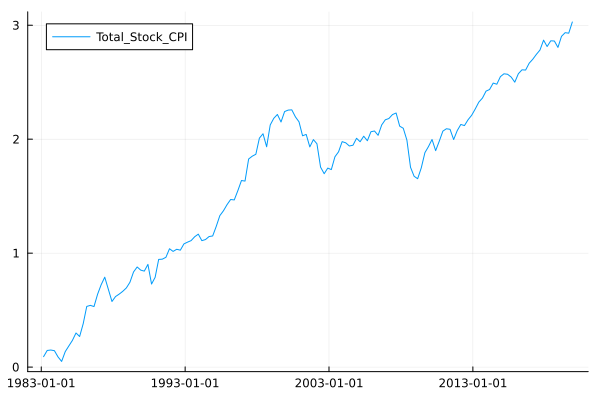

In [10]:
plot(cumsum(s_data[:Total_Stock_CPI]))

In [82]:
cape = collapse(data_source[:CAPE], Dates.quarter, last)
Δcape = percentchange(cape, :log)
adj_returns = returns[:Total_Stock] .- Δcape
returns_summarystats(merge(returns[:Total_Stock], adj_returns, Δcape),4)


,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.1368,0.8255,0.1042,0.2741,-1.0147,-0.6199,-0.0406,0.1422,1.2115,0.7619,0.1269
Total_Stock_CAPE,0.0235,0.2429,0.0901,0.1166,-0.1095,0.0858,0.0628,0.6842,1.2777,3.8333,0.0854
CAPE,0.1412,0.7461,0.0142,0.2052,-0.9743,-0.4754,-0.1406,0.165,0.6997,0.1002,0.0361


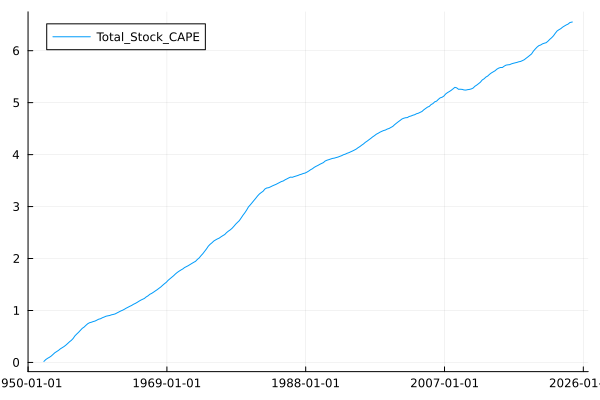

In [37]:
plot(cumsum(adj_returns))


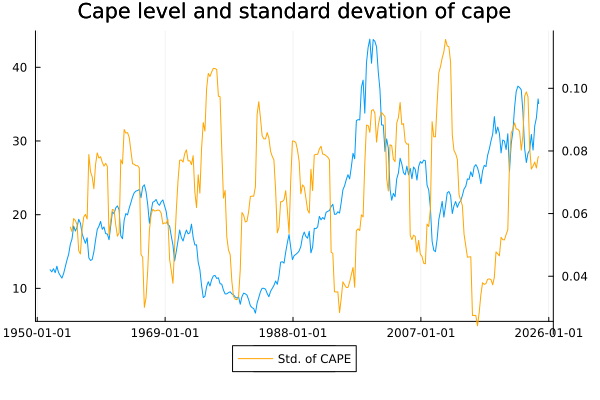

In [91]:
stdcape = moving(std,Δcape,12)
plot(cape, label="CAPE")
plot!(twinx(),stdcape, color=:orange, label="Std. of CAPE")
plot!(legend=:outerbottom)
title!("Cape level and standard devation of cape")

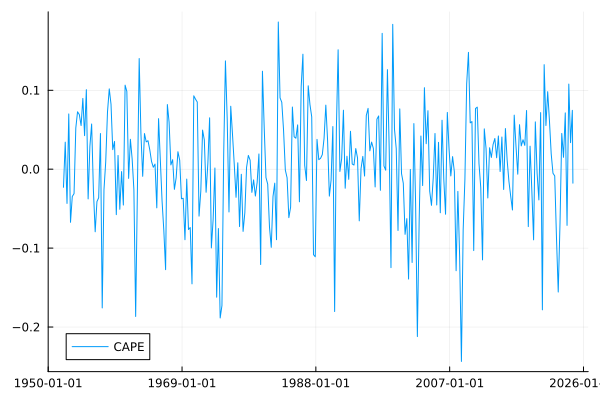

In [92]:
plot(Δcape)

In [54]:
r = returns[:Total_Stock]
sqrt(mean((values(r) .-  mean(values(r))) .^ 2))

0.06828153958153331

In [55]:
sqrt(mean((values(r) .-  mean(values(adj_returns))) .^ 2))

0.06837317748891925

In [42]:
std(values(returns[:Total_Stock]))

0.06839916505990531

In [41]:
std(values(returns[:Total_Stock]), mean=mean(values(adj_returns)))

0.06849096082771383

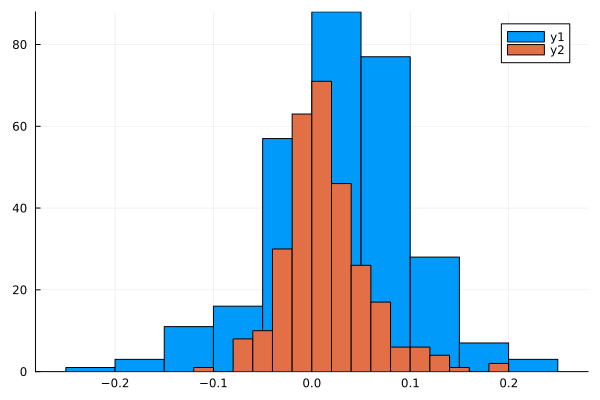

In [64]:
histogram(expm1.(values(returns[:Total_Stock]) ))
histogram!(expm1.(values(returns[:Price_10Y]) ))

In [93]:
returns_summarystats(data_source[:Yeld_10Y],1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Yeld_10Y,0.0292,0.1584,0.0548,0.0736,0.0066,0.9377,0.0333,0.9774,0.6945,1.8772,0.0468
